22.0 +/- 1.9
19.6 +/- 1.7


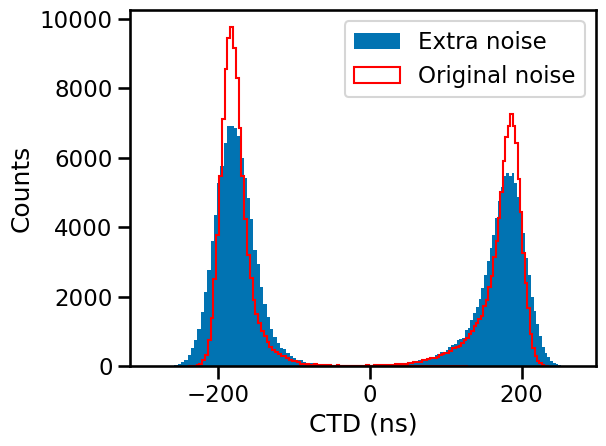

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_APRA_v2.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_dc.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

plt.figure()
plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
plt.legend()
plt.xlabel('CTD (ns)')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

# Look at all Cs137 data prior to Loma Linda

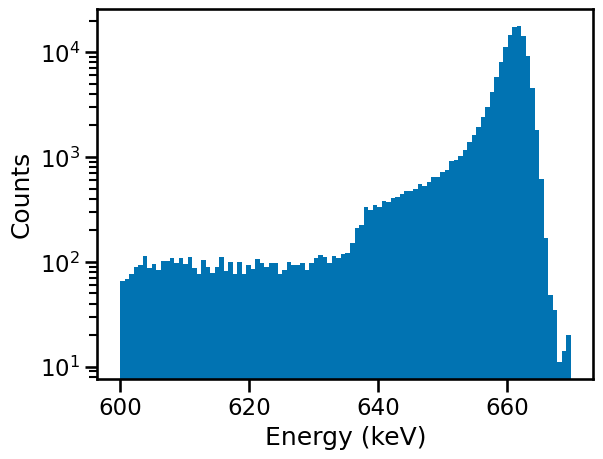

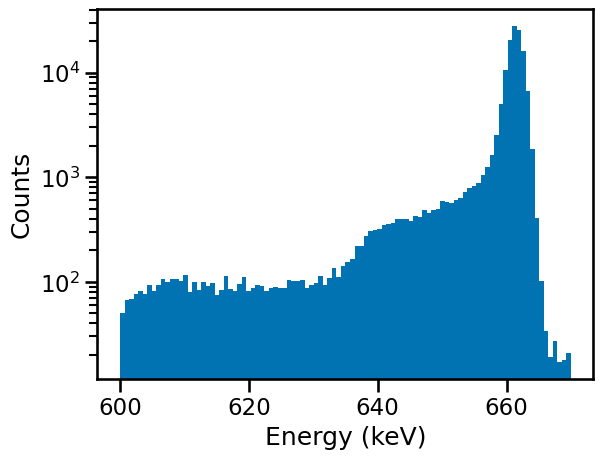

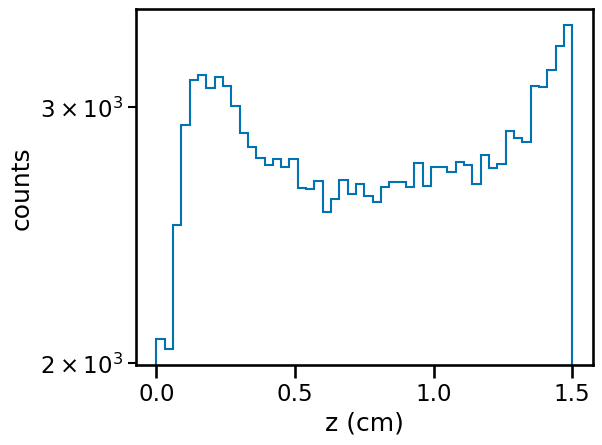

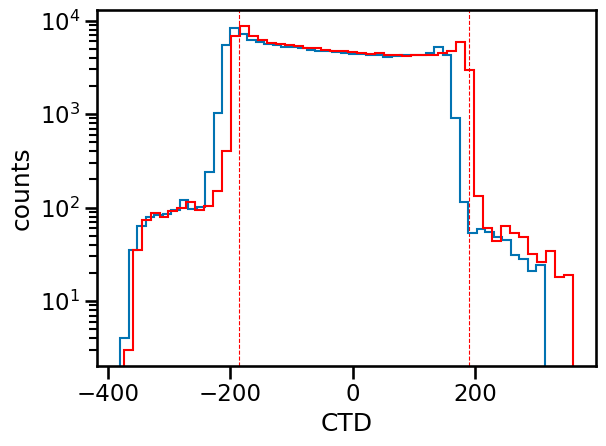

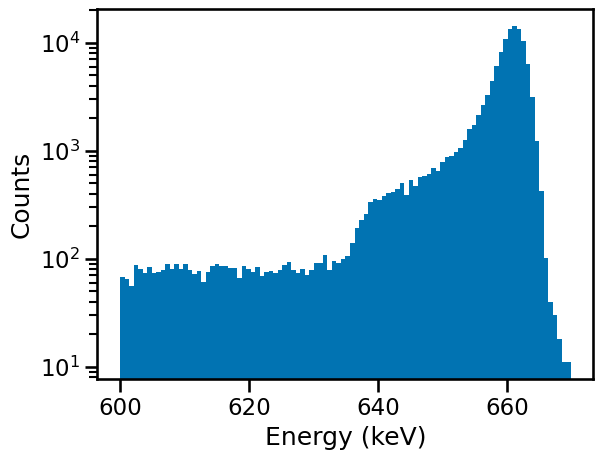

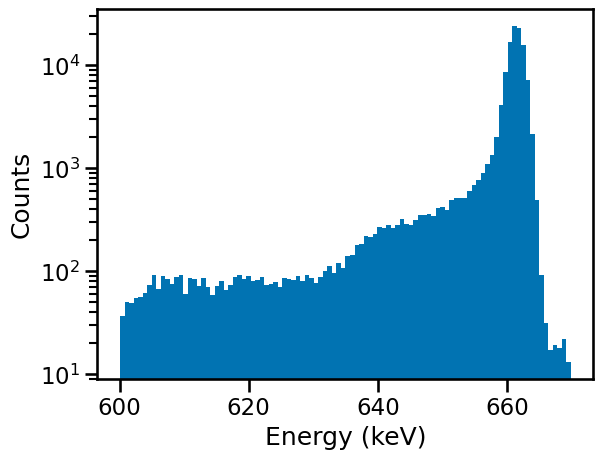

In [ ]:
AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_preLL', 'allDC_preLL', 'allACandDC_preLL']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'preLL/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()

    plt.figure()
    plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(0,1.5))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1])

# Do the same for the data after LL round 1

In [ ]:
AC_list = ['20231030_Cs137_AC_600V.dat', '20231031_Cs137_AC_600V.dat', '20231101_Cs137_AC_600V.dat', '20231102_Cs137_AC_600V_1.dat', '20231102_Cs137_AC_600V_2.dat']
DC_list = ['20231030_Cs137_DC_600V_1.dat', '20231030_Cs137_DC_600V_2.dat', '20231031_Cs137_DC_600V.dat', '20231101_Cs137_DC_600V_1.dat', '20231101_Cs137_DC_600V_2.dat', '20231102_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL1', 'allDC_postLL1', 'allACandDC_postLL1']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL1/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()

    plt.figure()
    plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(0,1.5))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postLL1, h_signal_postLL1 = make_depthplot(df_list[-1], strings[-1])

In [ ]:
plt.figure()
plt.errorbar(z_list, e_signal_preLL[0], xerr = 0.025, yerr=e_signal_preLL[1], fmt=".",label="undamaged")
plt.errorbar(z_list, e_signal_postLL1[0], xerr = 0.025, yerr=e_signal_postLL1[1],fmt=".",label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=4)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'e_trapping_before_afterLL1.pdf')
plt.close()

plt.figure()
plt.errorbar(z_list, h_signal_preLL[0], xerr = 0.025, yerr=h_signal_preLL[1], fmt=".",label="undamaged")
plt.errorbar(z_list, h_signal_postLL1[0], xerr = 0.025, yerr=h_signal_postLL1[1],fmt=".",label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=3)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'hole_trapping_before_after.pdf')
plt.close()


# Perform correction using spline

In [ ]:
df = depth_correction(df, z_list, e_signal_postLL1, h_signal_postLL1, plot_suffix = 'allACandDC_postLL1')

In [13]:
splines = {'p': UnivariateSpline(z_bins[z_list], centroid_list.T[0]), 'n': UnivariateSpline(z_bins[z_list], centroid_list.T[1])}
spline_hull = UnivariateSpline(z_bins[z_list], centroid_hull)
xs = np.linspace(np.min(z_bins[z_list]) - 1.5/(num_z*2.), np.max(z_bins[z_list]) + 1.5/(num_z*2.))
plt.figure()
if pnflipped[det]:
    plt.errorbar(z_bins[z_list]-top+1.5/(num_z*2.),centroid_list.T[0],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[0],fmt=" ",label="electron signal")
    plt.errorbar(z_bins[z_list]-top+1.5/(num_z*2.),centroid_list.T[1],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[1],fmt=" ",label="hole signal")
    plt.errorbar(z_bins[z_list]-top+1.5/(num_z*2.),centroid_hull, xerr = 1.5/(num_z*2.), yerr=centroid_err_hull,fmt=" ",label="mean signal", color='black', zorder=0)
    plt.plot(xs-top+1.5/(num_z*2.), splines['p'](xs), zorder=0, color='C0', ls = '--', lw = 0.75)
    plt.plot(xs-top+1.5/(num_z*2.), splines['n'](xs), zorder=0, color='C1', ls = '--', lw = 0.75)
    plt.plot(xs-top+1.5/(num_z*2.), spline_hull(xs), zorder=0, color='black', ls = '--', lw = 0.75)
else:
    plt.errorbar(top - z_bins[z_list]-1.5/(num_z*2.),centroid_list.T[0],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[0],fmt=" ",label="electron signal")
    plt.errorbar(top - z_bins[z_list]-1.5/(num_z*2.),centroid_list.T[1],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[1],fmt=" ",label="hole signal")
    plt.errorbar(top - z_bins[z_list]-1.5/(num_z*2.),centroid_hull,xerr = 1.5/(num_z*2.), yerr=centroid_err_hull, fmt=" ", label="mean signal", color='black', zorder=0)
    plt.plot(top - xs-1.5/(num_z*2.), splines['p'](xs), zorder=0, color='C0', ls = '--', lw = 0.75)
    plt.plot(top - xs-1.5/(num_z*2.), splines['n'](xs), zorder=0, color='C1', ls = '--', lw = 0.75)
    plt.plot(top - xs-1.5/(num_z*2.), spline_hull(xs), zorder=0, color='black', ls = '--', lw = 0.75)
plt.axhline(Cs_line, ls='--', color='C2', zorder=0)
plt.legend()
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# if pnflipped[det]:
#     plt.gca().invert_xaxis()
plt.ylim((659.6, 662.))
plt.tight_layout()
# plt.savefig(plot_dir + 'e_hole_trapping_det' + str(det) + '_spline_withHull.pdf')
plt.savefig(plot_dir + 'e_hole_trapping_det' + str(det) + '_spline.pdf')
plt.close()

### Correct the spectra on each side, separately.
z_corr_factor = {"p": Cs_line/np.array(centroid_list.T[0]), "n": Cs_line/np.array(centroid_list.T[1])}

# xs = np.linspace(650, 672, int(1e6))
for j, side in enumerate(z_corr_factor):
    print(side + '-side')
    color = 'C' + str(j)

    uncorr_energies = []
    corr_energies = []

    for i in range(num_z):

        z = z_freq_depthsort[i]
        z_cm = z_bins[z]

        uncorr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values)
        corr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values * Cs_line/splines[side](df_dat_det[df_dat_det["z_binned"]==z]['z'].values))

    uncorr_energies = np.concatenate(uncorr_energies)
    corr_energies = np.concatenate(corr_energies)

    uncorr_energies = uncorr_energies[uncorr_energies > 645.]
    corr_energies = corr_energies[corr_energies > 645.]

    plt.figure()
    hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
    hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

    # Plot uncorrected data
    bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
    c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
               Emin=645., Emax=672.)
    m.limits["x0"] = (650., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 645., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Uncorrected FWHM: ", round(2.355*m.values['sigma_gauss'], 5), ' +/- ', round(2.355*m.errors['sigma_gauss'], 5))
    print('1 - Uncorrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
      round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))

    temp_sigma_uncorr = m.values['sigma_gauss']
    temp_sigma_err_uncorr = m.errors['sigma_gauss']

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C3', lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C3')


    # Next plot corrected data
    bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
    c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
               Emin=645., Emax=672.)
    m.limits["x0"] = (650., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 645., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Corrected FWHM: ", round(2.355*m.values['sigma_gauss'], 5), ' +/- ', round(2.355*m.errors['sigma_gauss'], 5))
    print('1 - Corrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
      round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))

    temp_sigma_corr = m.values['sigma_gauss']
    temp_sigma_err_corr = m.errors['sigma_gauss']

    print('Delta FWHM:', round(2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)), 5), ' +/- ', \
      round(2.355*np.sqrt(np.square(temp_sigma_corr*temp_sigma_err_corr)+\
                          np.square(temp_sigma_uncorr*temp_sigma_err_uncorr))/np.sqrt(np.square(temp_sigma_uncorr)-np.square(temp_sigma_corr)), 5))

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C2', lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C2')


    if side =='p':
        plt.text(653., np.max(hist_corr)*0.2, 'electron signal', color='C0', fontsize=18)
    else:
        plt.text(653., np.max(hist_corr)*0.2, 'hole signal', color='C1', fontsize=18)


    plt.ylabel("Counts")
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.ylim((40., np.max(hist_corr)*1.5))
    plt.xlim(652.,665.)
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_' + side + '_spline.pdf')
    plt.close()

### Produce corrected spectra averaging between sides
uncorr_energies = []
corr_energies = []

# xs = np.linspace(650, 672, int(1e6))
for i in range(num_z):

    z = z_freq_depthsort[i]
    z_cm = z_bins[z]

    uncorr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, \
                                    df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values], axis=0))
    corr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values * Cs_line/splines['p'](df_dat_det[df_dat_det["z_binned"]==z]['z'].values), \
                                  df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values * Cs_line/splines['n'](df_dat_det[df_dat_det["z_binned"]==z]['z'].values)], axis=0))
uncorr_energies = np.concatenate(uncorr_energies)
corr_energies = np.concatenate(corr_energies)


uncorr_energies = uncorr_energies[uncorr_energies > 652.]
corr_energies = corr_energies[corr_energies > 652.]

plt.figure()
hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

print('----Combined signal----')
# Plot uncorrected data
bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
           Emin=652., Emax=672.)
m.limits["x0"] = (640., 672.)
m.limits["BoverA", "sigma_gauss"] = (0, None)
m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
m.migrad()
m.hesse()

BoverA, x0, sigma_gauss = m.values[:3]
A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
    quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
# print(m.values)
# print(m.errors['x0'])
B = A*BoverA
C = B*global_CoverB

print("Uncorrected FWHM: ", round(2.355*m.values['sigma_gauss'], 6), ' +/- ', round(2.355*m.errors['sigma_gauss'], 6))
print('1 - Uncorrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
      round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
temp_sigma_uncorr = m.values['sigma_gauss']
temp_sigma_err_uncorr = m.errors['sigma_gauss']

# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
# roots = spline.roots() # find the roots
# fwhm_uncorr=roots[1] - roots[0]
# print("uncorrected FWHM: " + str(roots[1] - roots[0]))
# plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
#          color='C3', fontsize=20)
# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
# roots = spline.roots() # find the roots
# print("uncorrected FWTM: " + str(roots[1] - roots[0]))


plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C3', lw=0.5)
# resid_ax.errorbar(bin_centers[hist>0], \
#                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
#                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
plt.axvline(m.values['x0'], ls='--', color='C3')


# Next plot corrected data
bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
           Emin=652., Emax=672.)
m.limits["x0"] = (650., 672.)
m.limits["BoverA", "sigma_gauss"] = (0, None)
m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
m.migrad()
m.hesse()

BoverA, x0, sigma_gauss = m.values[:3]
A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
    quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
# print(m.values)
# print(m.errors['x0'])
B = A*BoverA
C = B*global_CoverB

print("Corrected FWHM: ", round(2.355*m.values['sigma_gauss'], 6), ' +/- ', round(2.355*m.errors['sigma_gauss'], 6))
print('1 - Corrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
      round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
print(A*np.sqrt(2)*m.values['sigma_gauss'])

temp_sigma_corr = m.values['sigma_gauss']
temp_sigma_err_corr = m.errors['sigma_gauss']

print('Delta FWHM:', round(2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)), 5), ' +/- ', \
      round(2.355*np.sqrt(np.square(temp_sigma_corr*temp_sigma_err_corr)+\
                          np.square(temp_sigma_uncorr*temp_sigma_err_uncorr))/np.sqrt(np.square(temp_sigma_uncorr)-np.square(temp_sigma_corr)), 5))

# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
# roots = spline.roots() # find the roots
# fwhm_uncorr=roots[1] - roots[0]
# print("uncorrected FWHM: " + str(roots[1] - roots[0]))
# plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
#          color='C3', fontsize=20)
# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
# roots = spline.roots() # find the roots
# print("uncorrected FWTM: " + str(roots[1] - roots[0]))


plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C2', lw=0.5)
# resid_ax.errorbar(bin_centers[hist>0], \
#                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
#                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
plt.axvline(m.values['x0'], ls='--', color='C2')
# plt.axvline(Cs_line, ls='--', color = 'cyan')

plt.text(653., np.max(hist_corr)*0.2, 'mean signal', color='black', fontsize=18)
plt.ylabel("Counts")
plt.yscale('log')
plt.ylim((40., np.max(hist_corr)*1.5))
plt.xlim(652.,665.)
plt.xlabel('Energy (keV)')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_bothsides_spline.pdf')
plt.close()


Det  2
p-side
Uncorrected FWHM:  2.85335  +/-  0.02018
1 - Uncorrected centroid/Cs_line: -3.1693855897752083  +/-  -0.01142
Corrected FWHM:  2.60887  +/-  0.0169
1 - Corrected centroid/Cs_line: -3.9584388889073905  +/-  0.05891
Delta FWHM: 1.15559  +/-  0.06276
n-side
Uncorrected FWHM:  2.68775  +/-  0.01526
1 - Uncorrected centroid/Cs_line: -3.005654852705641  +/-  -0.00592
Corrected FWHM:  2.65724  +/-  0.01509
1 - Corrected centroid/Cs_line: -4.604498734854217  +/-  -0.23206
Delta FWHM: 0.40383  +/-  0.14207
----Combined signal----
Uncorrected FWHM:  2.124345  +/-  0.015986
1 - Uncorrected centroid/Cs_line: -3.029606204082919  +/-  -0.00679
Corrected FWHM:  2.083581  +/-  0.014702
1 - Corrected centroid/Cs_line: -4.8736949378461984  +/-  -0.44179
1706.97679087517
Delta FWHM: 0.41417  +/-  0.11043
Det  4
p-side
Uncorrected FWHM:  3.12493  +/-  0.01416
1 - Uncorrected centroid/Cs_line: -3.3287666000932363  +/-  -0.01166
Corrected FWHM:  2.99097  +/-  0.01338
1 - Corrected centroid/Cs_